In [ ]:
################################################################
#             This code belogs to Kevin J. Joven               #
################################################################
# This code is the complete resolution of the QPE algorithm for
# any given matrix. For instance, the H2 Hamiltonian in this
# work.
# Last update: 06/20/2024
################################################################

In [2]:
# Require installations.
!pip install scipy
!pip install qiskit==1.1.0
!pip install qiskit qiskit-aer==0.14.0.1
!pip install pennylane==0.35.0
!pip install openfermionpyscf
!pip install pylatexenc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 12.9 MB/s eta 0:00:00
  Attempting uninstall: qiskit-aer
    Found existing installation: qiskit-aer 0.15.1
    Uninstalling qiskit-aer-0.15.1:
      Successfully uninstalled qiskit-aer-0.15.1


In [3]:
# Import necessary libraries
import scipy as sc
import numpy as np
import re
from qiskit import QuantumCircuit
from qiskit.circuit.library import QFT, StatePreparation
from qiskit.visualization import plot_histogram
from qiskit import transpile, assemble
from qiskit_aer import Aer
from itertools import product
from qiskit.quantum_info import SparsePauliOp, PauliList
from pennylane import qchem
import matplotlib.pyplot as plt
####
from qiskit.providers.fake_provider import GenericBackendV2

## Supporting Functions

In [4]:
# Support functions
# Taken from my previous codes:https://github.com/KevinJoven11/Quantum-Computing/blob/main/Pauli_Decomposition.ipynb

def Decomposition(A):

    Pauli_Matrices = ['I', 'X', 'Y', 'Z']
    Tras = []
    dim = int(np.log2(len(A)))

    I = np.array([[1,0],[0,1]])
    X = np.array([[0,1],[1,0]])
    Y = np.array([[0, -1j],[1j, 0]])
    Z = np.array([[1,0],[0,-1]])

    Permutations = []
    for i in product(Pauli_Matrices, repeat = dim):
        Permutations.append(i)

    Matrices = Permutations.copy()

    for j in range(len(Matrices)):
        Res = 1
        for i in range(len(Matrices[0])):
            if Matrices[j][i] == 'I':
                Res = np.kron(I,Res)
            elif Matrices[j][i] == 'X':
                Res = np.kron(X,Res)
            elif Matrices[j][i] == 'Y':
                Res = np.kron(Y,Res)
            else:
                Res = np.kron(Z,Res)
        Tras.append(Res)

    coefficiens = []

    for i in range(len(Tras)):
        coefficiens.append((1/2**dim)*np.trace(np.dot(Tras[i],A)))

    Decomposition_List = {''.join(Permutations[i]): coefficiens[i] for i in range(len(Permutations))}

    return Decomposition_List

### This function give me the circuit representation of a given Pauli list
# Taken from my previous codes: https://github.com/KevinJoven11/Quantum-Computing/blob/main/Trotter/py_functions/H_Evolution.py

def parity(array):
    resultados = []
    indice_anterior = None
    for i, num in enumerate(array[0]):
        if num == '1':
            if indice_anterior is not None:
                resultados.append([indice_anterior, i])
            indice_anterior = i
    return resultados

def convertir_array(array):
    nuevo_array = ['1' if char != 'I' else '0' for char in array[0]]
    return [nuevo_array]

def encontrar_ultimo_uno(array):
    posicion_ultimo_uno = None

    for i in range(len(array[0])-1, -1, -1):
        if array[0][i] == '1':
            posicion_ultimo_uno = i
            break
    return posicion_ultimo_uno

def exp_h(pauli, prob, t, n):

    list_opt = list(pauli.keys())
    dim_opt = len(list_opt[0])

    qc = QuantumCircuit(dim_opt)

    pos = 0

    for i in range(0, len(prob)):
        if prob[i] != 0.0 or prob[i] != 0j:

            #############################
            array_unos = convertir_array([list_opt[i]])

            contador_uno = 0

            for sublista in array_unos:
                for elemento in sublista:
                    if elemento == '1':
                        contador_uno += 1

            if contador_uno == 1:
                for k in list_opt[i]:
                    if k == 'Z':
                        qc.rz((np.real(prob[i])*2*t)/n, encontrar_ultimo_uno(array_unos))
                    elif k == 'X':
                        qc.rx((np.real(prob[i])*2*t)/n, encontrar_ultimo_uno(array_unos))
                    elif k == 'Y':
                        qc.ry((np.real(prob[i])*2*t)/n, encontrar_ultimo_uno(array_unos))

            #############################
            else:

                for j in list_opt[i]:
                    if j == 'X':
                        qc.ry(np.pi/2, pos)
                    elif j == 'Y':
                        qc.rx(np.pi/2, pos)
                    pos = pos + 1

                pos = 0

                array_unos = convertir_array([list_opt[i]])
                array_cnots = parity(array_unos)

                for cnot_iter in array_cnots:
                    qc.cx(cnot_iter[0], cnot_iter[1])

                qc.rz((np.real(prob[i])*2*t)/n, encontrar_ultimo_uno(array_unos))

                for cnot_iter in reversed(array_cnots):
                    qc.cx(cnot_iter[0], cnot_iter[1])

                for j in list_opt[i]:
                    if j == 'X':
                        qc.ry(-np.pi/2, pos)
                    elif j == 'Y':
                        qc.rx(-np.pi/2, pos)
                    pos = pos + 1

                pos = 0

    return qc

def Exp_evolution(pauli, prob, t, n):

        list_opt = list(pauli.keys())
        dim_opt = len(list_opt[0])

        qc = QuantumCircuit(dim_opt)

        ### Exponential circuit
        exp = exp_h(pauli, prob, t, n)
        qc_exp = QuantumCircuit(dim_opt)
        qc_exp.append(exp, list(np.arange(0,dim_opt)))

        ### Repetition circuit.
        for i in np.arange(n):
            qc.append(qc_exp, list(np.arange(0,dim_opt)))

        return qc

## Auxiliar functions to work with the dictionaries:
def separar_letras_y_numeros(cadena):
    letras = re.findall('[A-Za-z]+', cadena)
    numeros = re.findall('\d+', cadena)
    return letras, numeros

def combinar_letras_numeros(letras, numeros, longitud):
    resultado = ['I'] * longitud
    for letra, numero in zip(letras, numeros):
        posicion = int(numero)
        resultado[posicion] = letra
    return ''.join(resultado)

def separar_constantes_y_listas(s):
    constantes = re.findall(r'\(([^)]+)\)', s)
    listas = re.findall(r'\[([^\]]+)\]', s)
    return constantes, listas

def convertir_a_float(lista):
    lista_float = [float(valor) for valor in lista]
    return lista_float

def crear_diccionario(lista_claves, lista_valores):
    diccionario = dict(zip(lista_claves, lista_valores))
    return diccionario

def give_hamiltonian(symbols, coordinates, basis, mult):
    H, qubits = qchem.molecular_hamiltonian(symbols, coordinates, method = "pyscf", basis=basis, mult=1) #dhf, pyscf
    Ham = str(H)

    opts_opt = []
    opts_pos = []
    pauli_str = []

    coeffs, opts = separar_constantes_y_listas(Ham)
    coeffs_values = convertir_a_float(coeffs)

    for i in opts:
        opts_opt.append(separar_letras_y_numeros(i)[0])
        opts_pos.append(separar_letras_y_numeros(i)[1])

    for i in range(0,len(opts_opt)):
        pauli_str.append(combinar_letras_numeros(opts_opt[i], opts_pos[i], qubits))

    pauli = crear_diccionario(pauli_str, coeffs_values)

    return pauli

def give_matrix(pauli):
    opt = [valor for valor in pauli.keys()]
    opt = PauliList(opt)
    coeffs = [valor for valor in pauli.values()]
    coeffs = np.array(coeffs)
    ham = SparsePauliOp(opt, coeffs)
    matrix = ham.to_matrix()
    return matrix

def filter(dict_opt, size):
        filter_dict = {k: v for k, v in dict_opt.items() if k != 'I'*size}
        return filter_dict

def is_hermitian(matrix):

    if matrix.shape[0] != matrix.shape[1]:
        return False
    conjugate_transpose = np.conjugate(matrix).T
    return np.allclose(matrix, conjugate_transpose)

def apply_threshold(dictionary, threshold_cut):
    for key, value in dictionary.items():
        if isinstance(value, (int, float)):
            if value < threshold_cut:
                dictionary[key] = 0
        elif isinstance(value, complex):
            if abs(value) < threshold_cut:
                dictionary[key] = 0
    return dictionary

## General Function

In [25]:
def QPE(matrix, n = 1, precision = 5, state = 0, information = False, threshold = 0.0):
  """ A function that implements the quantum phase
  estimation algorithm in qiskti for a given matrix.

  Args:
    matrix (np.array) : matrix to calculate.
    n (int) : trotter order for non-unitary matrices.
    precision (int) : number of qubit for the precision
    register.
    state (int) : state to be calculate. If none,
    it calculates the ground state.
    information (bool) : If you want that show information
    about the circuit itself.
    threshold (float): If you want to cut some values in the
    dictionary before to create the quantum circuit. Be careful!

  Returns:
    eig (float) : eigenvalue of a given state.

  """

  # calculate the eigenvalues and the eigenvectors.
  values, vectors = np.linalg.eigh(matrix)

  # shown some information.
  if information == True:
    print("The eigenvalues are: {}".format(values))
    print("Matrix shape: {}".format(np.shape(matrix)))
    print("Required qubits: {}".format(int(np.log2(np.shape(matrix)[0]))))

  # decompose the matrix into Pauli operators to pass to the quantum circuit.
  dict_values = Decomposition(matrix)
  pauli = dict(zip(dict_values.keys(), dict_values.values()))
  list_opt = list(pauli.keys())
  dim_opt = len(list_opt[0]) # get the dimension
  I_value = list(pauli.values())[0] # get the identity register.
  pauli = filter(pauli, dim_opt) # filter the identity register.
  pauli = apply_threshold(pauli, threshold) # threshold function
  prob = np.array(list(pauli.values())) # get the probability for each opt.

  t = 1 # time for the evolution, this is just an factor in the code.

  ### Exponential circuit
  prep = Exp_evolution(pauli, prob, t, n)

  ### Repetition
  qc_opt = QuantumCircuit(dim_opt)
  qc_opt.append(prep, list(np.arange(0,dim_opt)))
  qc = qc_opt.decompose().decompose().decompose().decompose()

  # Control version of the gate.
  qc_control_opt = qc.control()

  # Circuit parameters
  precision_register = precision
  operator_register = int(np.log2(np.shape(matrix)[0]))
  total_qubits = precision_register + operator_register

  # Define the quantum circuit
  qc = QuantumCircuit(total_qubits, total_qubits)

  # Add Hamadard gates
  qc.h(np.arange(0,precision_register))

  # Initial state : Here we know the state, usually this do not happends and we
  # need to implement a sub-rutine such as VQE. which have some overlap with
  # excited states.
  initial_state = StatePreparation(vectors[:,state])
  qc.append(initial_state, list(np.arange(precision_register, total_qubits)))

  # Define the inverse QFT.
  qf = QFT(precision_register, inverse=True)

  # This is the control operator loop.
  for i in np.arange(0, precision_register):
      for j in range(0,2**i):
          qc.append(qc_control_opt,[i]+list(np.arange(precision_register, total_qubits)))

  # Add the inverse QFT to the circuit
  qc.append(qf, list(np.arange(0,precision_register)))

  # Measure the precision register.
  qc.measure(list(np.arange(0,precision_register)),list(np.arange(0,precision_register)))

  ## Simulation of the circuit

  ### Normal Simulation

  #backend = GenericBackendV2(num_qubits=total_qubits)
  #transpiled_circuit = transpile(qc, backend)
  #job = backend.run(transpiled_circuit)
  #result = job.result().get_counts()

  ### Noise Simulation with noisy-backend

  Simulation = Aer.get_backend('qasm_simulator')
  Quantum_Transpiler = transpile(qc,Simulation)
  Quantum_Obj = assemble(Quantum_Transpiler, shots=1000)
  result = Simulation.run(Quantum_Obj).result().get_counts()

  # What is the max value in the register?
  max_value = int(max(result, key=result.get),2)
  val = max_value/(2**precision_register)
  if val <= 0.5:
    eig = val*2*np.pi/t - I_value
  else:
    eig = (val-1)*2*np.pi/t - I_value

  eig = -eig

  if information == True:
    print("Max value register: {}".format(max_value))
    print("Phase estimation = {}".format(val))
    print("Eigenvalue = {}".format(np.abs(eig)))
    #print("Circuit gate counts: {}".format(qc.decompose().decompose().decompose().decompose().decompose().decompose().decompose().decompose().count_ops()))
    #print(qc.draw())

    ####### RESULTS #######
    print("========================================")
    print("======        RESULTS          =========")
    print("========================================")
    print("\n")
    print("Real eigenvalue: {}".format(values[state]))
    print("Calculated eigenvalue: {}".format(np.real(eig)))
    print("Error {}".format(np.abs(np.abs(values[state])-np.abs(np.real(eig)))))
    print("\n \n \n")

  return eig

# Testing the Circuit

## Normal matrices

In [41]:
# circuit testing.
matrix_system = np.array([[1,0,0,0],[0,1.5,0,0],[0,0,2,0],[0,0,0,2.5]])*-1.0

print(is_hermitian(matrix_system))

# real values:
values, vectors = np.linalg.eigh(matrix_system)
values

True


array([-2.5, -2. , -1.5, -1. ])

In [27]:
n = 1 # trotter order
state = 0 # ground state
precision = 8 # precision qubits
information = True # want to see more information?
th = 0.0

# Run the function
QPE(matrix_system, n, precision, state, information, th)

The eigenvalues are: [-2.5 -2.  -1.5 -1. ]
Matrix shape: (4, 4)
Required qubits: 2
Max value register: 31
Phase estimation = 0.12109375
Eigenvalue = 2.510854470791278
======        RESULTS          =========


Real eigenvalue: -2.5
Calculated eigenvalue: -2.510854470791278
Error 0.010854470791278104

 
 



<ipython-input-25-128aa662d4ba>:99: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.14 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  result = Simulation.run(Quantum_Obj).result().get_counts()


-2.510854470791278

As you can see the value is really close with an error of 0.0108. You can decrease the error while increasing the number of precision qubits.

In [36]:
# Plotting all the eigenvalues given the precision qubits.
information = False

# from 3 qubits to 10 qubits for the all 4 eigenvalues.
eig_values = np.zeros([4,8])

for i in range(0,4):
  for j in range(0,8):
    eig_values[i,j] = QPE(matrix_system, n, j+3, i, information, th)

<ipython-input-25-128aa662d4ba>:99: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.14 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  result = Simulation.run(Quantum_Obj).result().get_counts()


In [38]:
eig_values

array([[-2.53539816, -2.53539816, -2.53539816, -2.53539816, -2.48631078,
        -2.51085447, -2.49858262, -2.49858262],
       [-1.75      , -2.14269908, -1.94634954, -2.04452431, -1.99543693,
        -1.99543693, -1.99543693, -2.00157285],
       [-1.75      , -1.35730092, -1.55365046, -1.45547569, -1.50456307,
        -1.50456307, -1.50456307, -1.49842715],
       [-0.96460184, -0.96460184, -0.96460184, -0.96460184, -1.01368922,
        -0.98914553, -1.00141738, -1.00141738]])

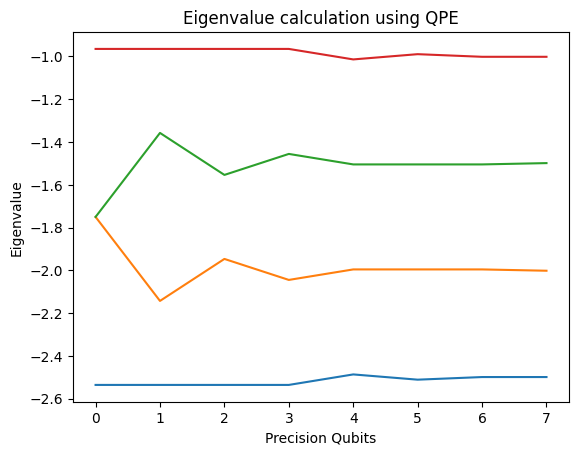

In [39]:
plt.plot(eig_values[0])
plt.plot(eig_values[1])
plt.plot(eig_values[2])
plt.plot(eig_values[3])
plt.title("Eigenvalue calculation using QPE")
plt.xlabel("Precision Qubits")
plt.ylabel("Eigenvalue")
plt.show()

## Let's try to do the same using a real example for the Hydrogen two $H_2$

In [42]:
# This code is for getting the matrix of H2 in the equilibrium position.
symbols = ["H","H"]
coordinates = np.array([-1.3893114065959864, 0.0, 0.0, 0.0, 0.0, 0.0])
matrix_system = give_matrix(give_hamiltonian(symbols, coordinates, 'sto-3g', mult=1))

is_hermitian(matrix_system)

True

In [43]:
values, vectors = np.linalg.eigh(matrix_system)
values

array([-1.13730596, -0.53644155, -0.53644155, -0.52485386, -0.52485386,
       -0.52485386, -0.44085464, -0.44085464, -0.16297005,  0.24776235,
        0.24776235,  0.36621401,  0.36621401,  0.49459728,  0.71978103,
        0.9338196 ])

In [60]:
# Plotting all the eigenvalues given the precision qubits.
information = False

num_values = 16
num_precision = 7
# from 3 qubits to 9 qubits for the all 4 eigen values.
eig_values = np.zeros([num_values, num_precision])

for i in range(0, num_values):
  for j in range(0, num_precision):
    eig_values[i,j] = QPE(matrix_system, n, j+3, i, information, th)

<ipython-input-25-128aa662d4ba>:99: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.14 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  result = Simulation.run(Quantum_Obj).result().get_counts()
<ipython-input-60-2ca681d294be>:11: ComplexWarning: Casting complex values to real discards the imaginary part
  eig_values[i,j] = QPE(matrix_system, n, j+3, i, information, th)


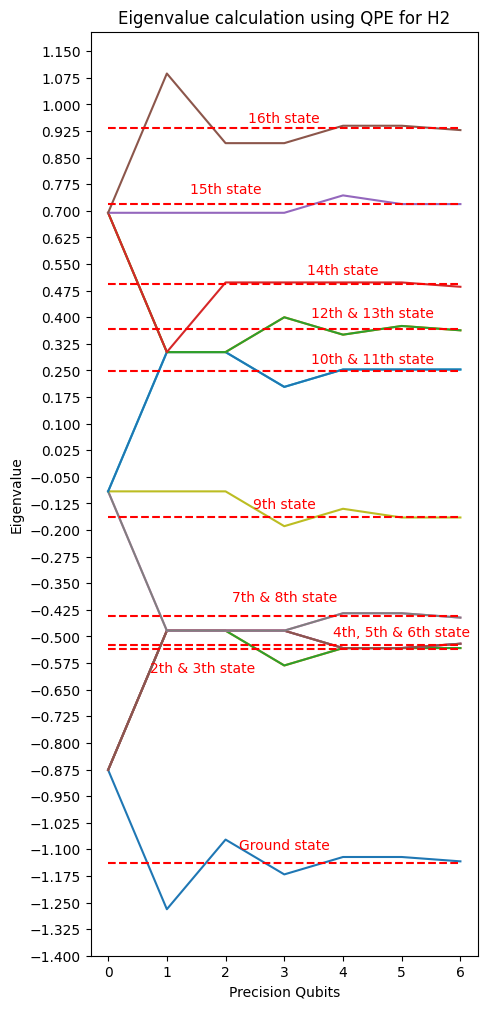

In [81]:
fig, axs = plt.subplots(1, 1, figsize=(5, 12))

for i in range(len(eig_values)):
  axs.plot(eig_values[i])

axs.text(3, -1.1, 'Ground state', ha='center', color='r')
axs.hlines(-1.13730596, 0, 6, 'r', linestyles='--')

axs.text(1.6, -0.6, '2th & 3th state', ha='center', color='r')
axs.hlines(-0.53644155, 0, 6, 'r', linestyles='--')

axs.text(5, -0.5, '4th, 5th & 6th state', ha='center', color='r')
axs.hlines(-0.52485386, 0, 6, 'r', linestyles='--')

axs.text(3, -0.4, '7th & 8th state', ha='center', color='r')
axs.hlines(-0.44085464, 0, 6, 'r', linestyles='--')

axs.text(3, -0.14, '9th state', ha='center', color='r')
axs.hlines(-0.16297005, 0, 6, 'r', linestyles='--')

axs.text(4.5, 0.27, '10th & 11th state', ha='center', color='r')
axs.hlines(0.24776235, 0, 6, 'r', linestyles='--')

axs.text(4.5, 0.4, '12th & 13th state', ha='center', color='r')
axs.hlines(0.36621401, 0, 6, 'r', linestyles='--')

axs.text(4, 0.52, '14th state', ha='center', color='r')
axs.hlines(0.49459728, 0, 6, 'r', linestyles='--')

axs.text(2, 0.75, '15th state', ha='center', color='r')
axs.hlines(0.71978103, 0, 6, 'r', linestyles='--')

axs.text(3, 0.95, '16th state', ha='center', color='r')
axs.hlines(0.9338196, 0, 6, 'r', linestyles='--')

axs.set_title("Eigenvalue calculation using QPE for H2")
axs.set_xlabel("Precision Qubits")
axs.set_ylabel("Eigenvalue")
yticks = np.arange(-1.4, 1.2, 0.075)
plt.yticks(yticks)
plt.show()